# Data format overview
## In this tutorial, we will overview evaluate the following data formats
1. avro (structured)
2. csv (semi-structured)
3. json (semi-structured)
4. orc (structured)
5. parquet (structured) 

## We evaluate the data formats via:
1. Disk usage
2. Read/Write latency
3. Random data lookup
4. Filtering/GroupBy(column-wise)
5. Distinct(row-wise)

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
       .builder.master("local[2]") \
       .appName("Python Spark SQL basic example") \
       .config("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.0.1") \
       .getOrCreate()

In [2]:
data_dir="/home/pliu/data_set/format_performence_test"
json_data_path=data_dir+"/netflix.json"
parquet_data_path=data_dir+"/netflix.parquet"
avro_data_path=data_dir+"/netflix.avro"
orc_data_path=data_dir+"/netflix.orc"
csv_data_path=data_dir+"/netflix.csv"

# Some useful functions for evaluating data format

### The read function read the source data file and convert it to a spark data frame

In [3]:
# file path for storing operation stats
data_format_op_stats_path="../tmp/op-stats.csv"

# file path for storing size stats
data_format_size_stats_path="../tmp/size-stats.csv"
def write_stats(line):
    file1 = open(data_format_op_stats_path,"a")
    file1.write(line+"\n")

In [4]:
import time
def read(fmt):
    start = time.time()
    if fmt == "json":
        sdf = spark.read.option("header", "true").json(json_data_path)
    elif fmt == "csv":
        sdf = spark.read.option("header", "true").csv(csv_data_path)
    elif fmt == "avro":
        sdf = spark.read.format("avro").load(avro_data_path)
    elif fmt == "parquet":
        sdf = spark.read.parquet(parquet_data_path)
    elif fmt == "orc":
        sdf = spark.read.orc(orc_data_path)
    sdf.show(5,False)
    stats="{}, {}, {}".format(fmt, "read", time.time() - start)
    write_stats(stats)
    print(stats)
    return sdf

### The get_shape function prints the shape(e.g. row number and column number) of the data frame

In [5]:
def get_shape(df,fmt):
    start = time.time()
    row_num=df.count()
    col_num=len(df.columns)
    stats="{}, {}, {}".format(fmt, "get_shape", time.time() - start)
    write_stats(stats)
    print("The data frame has {} rows and {} columns".format(row_num,col_num))
    print(stats)

### The stats function prints the min, max and numbers of a column of the data frame

In [6]:
def stats(df,fmt, field="rating"):
    start = time.time()
    max=df.agg({field: "max"})
    min=df.agg({field: "min"})
    count=df.agg({field: "count"})
    min.show(5,False)
    max.show(5,False)
    count.show(5,False)
    stats="{}, {}, {}".format(fmt, "stats", time.time() - start)
    write_stats(stats)
    print(stats)

### The random_batch function randomly select rows from the data frame. It can evaluate the ability of random data lookup

In [7]:
def random_batch(df,fmt):
    start = time.time()
    result=df.sample(False, 0.05).collect()
    stats="{}, {}, {}".format(fmt, "random_batch", time.time() - start)
    write_stats(stats)
    print(stats)
   # return result

### The distinct function count distinct rows of the data frame

In [8]:
def distinct(df,fmt):
    start = time.time()
    result = df.distinct().count()
    stats="{}, {}, {}".format(fmt, "distinct", time.time() - start)
    write_stats(stats)
    print(stats)
    return result

### The group_by function group and count the data frame by a specific column

In [9]:
def group_by(df,fmt):
    start = time.time()
    result=df.groupBy("rating").count()
    result.show(5,False)
    stats="{}, {}, {}".format(fmt, "group_by", time.time() - start)
    write_stats(stats)
    print(stats)
    #return result

### The filtering function filter data by using a specific boolean condition

In [10]:
def filtering(df, fmt, date="2005-11-15"):
    start = time.time()
    result = df.filter(df.date > date).count()
    stats="{}, {}, {}".format(fmt, "filtering", time.time() - start)
    write_stats(stats)
    print(stats)
    return result

In [11]:
def saveCSV(df,outputPath,fileName): Unit ={
    df.coalesce(1).write.mode("overwrite")
      .option("header","true")
      .option("mapreduce.fileoutputcommitter.marksuccessfuljobs","false")
      .option("encoding", "UTF-8")
      .option("delimiter", ",") 
      .csv(outputPath+"/"+fileName)
  }   

# 1. Gathering stats of each data format

## 1.1 Get CSV format evaluation stats

In [12]:
csv_df=read("csv")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|1488844|3     |2005-09-06|
|822109 |5     |2005-05-13|
|885013 |4     |2005-10-19|
|30878  |4     |2005-12-26|
|823519 |3     |2004-05-03|
+-------+------+----------+
only showing top 5 rows

csv, read, 8.12546992301941


In [82]:
csv_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- date: string (nullable = true)



In [83]:
get_shape(csv_df,"csv")

The data frame has 24058262 rows and 3 columns
csv, get_shape, 4.477824687957764


In [84]:
# get min, max and row number of column rating
stats(csv_df,"csv",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

csv, stats, 32.75556993484497


In [85]:
random_batch(csv_df,"csv")

csv, random_batch, 14.378179788589478


In [86]:
distinct(csv_df,"csv")

csv, distinct, 34.869959354400635


12168704

In [87]:
group_by(csv_df,"csv")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

csv, group_by, 8.922224283218384


In [88]:
filtering(csv_df,"csv")

csv, filtering, 6.7455198764801025


850269

## 1.2 Get Json format evaluation stats

In [89]:
json_df=read("json")

+----------+------+-------+
|date      |rating|user_id|
+----------+------+-------+
|2005-09-06|3     |1488844|
|2005-05-13|5     |822109 |
|2005-10-19|4     |885013 |
|2005-12-26|4     |30878  |
|2004-05-03|3     |823519 |
+----------+------+-------+
only showing top 5 rows

json, read, 8.587502479553223


In [90]:
get_shape(json_df,"json")

The data frame has 24058262 rows and 3 columns
json, get_shape, 6.804990530014038


In [91]:
# get min, max and row number of column rating
stats(json_df,"json",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

json, stats, 27.140789031982422


In [92]:
random_batch(json_df,"json")

json, random_batch, 13.582443475723267


In [93]:
distinct(json_df,"json")

json, distinct, 39.76104497909546


12168704

In [94]:
group_by(json_df,"json")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

json, group_by, 9.966024398803711


In [95]:
filtering(json_df,"json")

json, filtering, 9.18294906616211


850269

## 1.3 Get Avro format evaluation stats

In [96]:
avro_df=read("avro")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|2584438|4     |2005-03-01|
|702567 |4     |2005-03-05|
|1253149|3     |2005-03-06|
|321108 |4     |2005-03-08|
|254824 |5     |2005-03-11|
+-------+------+----------+
only showing top 5 rows

avro, read, 0.14605450630187988


In [97]:
get_shape(avro_df,"avro")

The data frame has 24058262 rows and 3 columns
avro, get_shape, 5.119563102722168


In [98]:
stats(avro_df,"avro",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

avro, stats, 14.71023941040039


In [99]:
random_batch(avro_df,"avro")

avro, random_batch, 8.214334726333618


In [100]:
distinct(avro_df,"avro")

avro, distinct, 27.276217937469482


12168704

In [101]:
group_by(avro_df,"avro")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

avro, group_by, 5.199187278747559


In [102]:
filtering(avro_df,"avro")

avro, filtering, 4.339125871658325


850269

## 1.4 Get Parquet format evaluation stats

In [103]:
parquet_df=read("parquet")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|2584438|4     |2005-03-01|
|702567 |4     |2005-03-05|
|1253149|3     |2005-03-06|
|321108 |4     |2005-03-08|
|254824 |5     |2005-03-11|
+-------+------+----------+
only showing top 5 rows

parquet, read, 0.974963903427124


In [104]:
get_shape(parquet_df,"parquet")

The data frame has 24058262 rows and 3 columns
parquet, get_shape, 0.22466778755187988


In [105]:
random_batch(parquet_df,"parquet")

parquet, random_batch, 5.618206977844238


In [106]:
stats(parquet_df,"parquet",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

parquet, stats, 3.7998757362365723


In [107]:
distinct(parquet_df,"parquet")

parquet, distinct, 25.151233673095703


12168704

In [108]:
group_by(parquet_df,"parquet")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

parquet, group_by, 1.042651891708374


In [109]:
filtering(parquet_df,"parquet")

parquet, filtering, 0.6861672401428223


850269

# 1.5 Get ORC format evaluation stats

In [110]:
orc_df=read("orc")

+-------+------+----------+
|user_id|rating|date      |
+-------+------+----------+
|2584438|4     |2005-03-01|
|702567 |4     |2005-03-05|
|1253149|3     |2005-03-06|
|321108 |4     |2005-03-08|
|254824 |5     |2005-03-11|
+-------+------+----------+
only showing top 5 rows

orc, read, 0.8232436180114746


In [111]:
get_shape(orc_df,"orc")

The data frame has 24058262 rows and 3 columns
orc, get_shape, 0.14114689826965332


In [112]:
random_batch(orc_df,"orc")

orc, random_batch, 5.064251899719238


In [113]:
stats(orc_df,"orc",field="rating")

+-----------+
|min(rating)|
+-----------+
|1          |
+-----------+

+-----------+
|max(rating)|
+-----------+
|5          |
+-----------+

+-------------+
|count(rating)|
+-------------+
|24053764     |
+-------------+

orc, stats, 3.4021592140197754


In [114]:
distinct(orc_df,"orc")

orc, distinct, 24.49589204788208


12168704

In [115]:
group_by(orc_df,"orc")

+------+-------+
|rating|count  |
+------+-------+
|3     |6904181|
|null  |4498   |
|5     |5506583|
|1     |1118186|
|4     |8085741|
+------+-------+
only showing top 5 rows

orc, group_by, 1.0796089172363281


In [116]:
filtering(orc_df,"orc")

orc, filtering, 0.5179171562194824


850269

# 2. Compare the stats of different format 

## 2.1 Visualize the read latency for each format

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
# define a schema
from pyspark.sql.types import StructType, StructField, DoubleType,StringType,LongType

op_schema = StructType([
    StructField("format", StringType(), True),
    StructField("command", StringType(), True),
    StructField("Latency", DoubleType(), True)])

size_schema = StructType([
    StructField("format", StringType(), True),
    StructField("size_kb", LongType(), True)])


# read stats file
rawDf=spark.read.option("header", "false").csv(data_format_op_stats_path,schema=op_schema)
rawDf.show(5)
rawDf.count()

+------+-------------+-------------------+
|format|      command|            Latency|
+------+-------------+-------------------+
|   csv|         read|0.25354528427124023|
|   csv|    get_shape|  4.477824687957764|
|   csv|        stats|  32.75556993484497|
|   csv| random_batch| 14.378179788589478|
|   csv|     distinct| 34.869959354400635|
+------+-------------+-------------------+
only showing top 5 rows



36

In [29]:
statsDf=rawDf.dropDuplicates(["format","command"])
statsDf.count()

35

In [30]:
pd_df=statsDf.toPandas()
pd_df.shape

(35, 3)

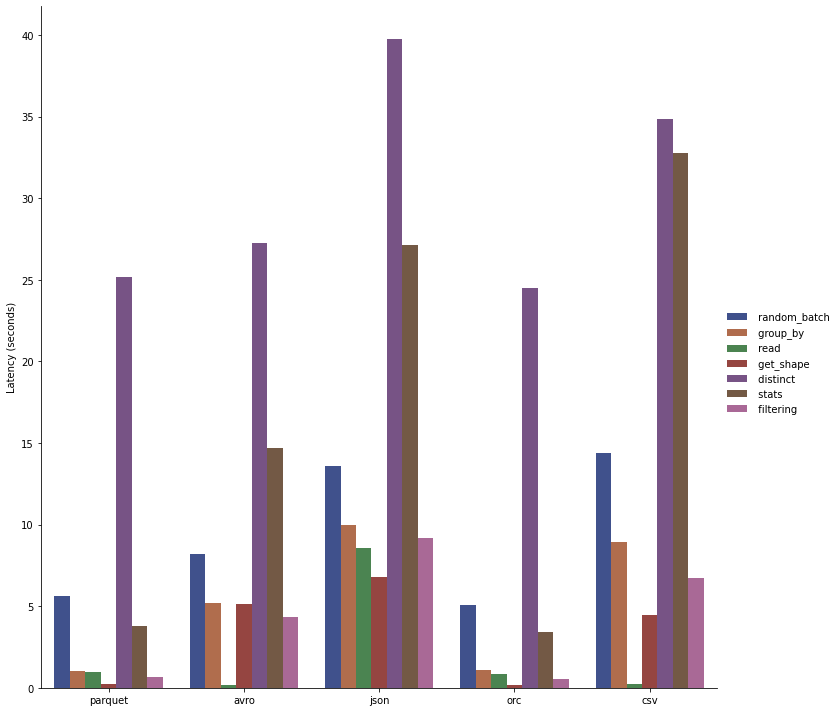

In [61]:
g_op = sns.catplot(
    data=pd_df, kind="bar",
    x="format", y="Latency", hue="command",
    ci="sd", palette="dark", alpha=0.8, height=10
)
g_op.despine(left=False)
g_op.set_axis_labels("", "Latency (seconds)")
g_op.legend.set_title(" ")


## Disk Usage for different  file format

In [79]:
# read size stats file
from pyspark.sql.functions import col
rawSizeDf=spark.read.option("header", "true").csv(data_format_size_stats_path,schema=size_schema)
sizeDf=rawSizeDf.withColumn("size_mb",col("size_kb")/1024)
sizeDf.show(5)

+-------+-------+------------+
| format|size_kb|     size_mb|
+-------+-------+------------+
|    orc| 191332|186.84765625|
|   avro| 286628|279.91015625|
|parquet| 202772|198.01953125|
|    csv| 483432| 472.1015625|
|   json|1292192|  1261.90625|
+-------+-------+------------+



In [69]:
pd_size_df=sizeDf.toPandas()

In [70]:
from matplotlib import pyplot as plt
import numpy as np

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

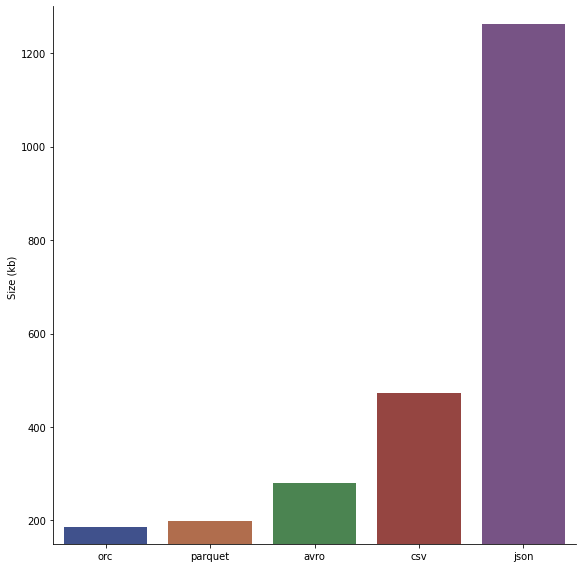

In [81]:
# 
g_size = sns.catplot(
    data=pd_size_df, kind="bar",
    x="format", y="size_mb", 
    order=['orc','parquet','avro','csv','json'],
    ci="sd", palette="dark", alpha=0.8, height=8
)
g_size.despine(left=False)
g_size.set_axis_labels("", "Size (kb) ")
g_size.set(ylim=(150, 1300))



# Stop the spark cluster

In [82]:
# stop sparksession
spark.sparkContext.stop()

### Check if the spark cluster is well closed. You should not see any python-spark pods

In [34]:
! kubectl get pods

NAME                                                     READY   STATUS      RESTARTS   AGE
deleting-pods-with-completed-status-1615824000-2nwxn     0/1     Completed   0          58m
jupyter-1615800186-567f67779b-cbmgx                      1/1     Running     0          7h35m
python-spark-sql-basic-example-6e3a6b7836d2d444-exec-1   1/1     Running     0          21s
python-spark-sql-basic-example-6e3a6b7836d2d444-exec-2   1/1     Running     0          21s
python-spark-sql-basic-example-6e3a6b7836d2d444-exec-3   1/1     Running     0          20s
python-spark-sql-basic-example-6e3a6b7836d2d444-exec-4   1/1     Running     0          20s
python-spark-sql-basic-example-6e3a6b7836d2d444-exec-5   1/1     Running     0          20s
ubuntu-1612965548-79c9567b44-nhs9p                       1/1     Running     1          33d
